In [201]:
#!pip install reverse_geocoder
#!pip install plotly_express

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import statsmodels.formula.api as sm
import plotly.graph_objects as go
import plotly_express as px

show_slow_maps = False #Some maps are very large and therefore slow down the notebook, set True to show them anyway

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

ERROR: Could not find a version that satisfies the requirement plotly-orca (from versions: none)
ERROR: No matching distribution found for plotly-orca


In [327]:
# Output
#  df_ts_complete: df with values where time series is complete
#  df_estimate: df where all time series values are NaN but there is an estimate
#  df_ts_incomplete: df with values where at least one of time series values is NaN
# 
# Reads global powerplant data data from CSV, drops irrelevant columns, splits df (see output), 
# and re-indexes df with gppdf_idnr as index
def read_clean_and_split():  
    df = pd.read_csv("data\global_power_plant_database.csv")
    df_all = df.drop(['country_long', 'url', 'geolocation_source', 'wepp_id'], axis=1)
    
    df_ts = (df_all.dropna(how='all', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
                      .set_index('gppd_idnr'))
    df_ts_complete = df_ts.dropna(how='any', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
    df_estimate = (df_all.dropna(how='any', subset=['estimated_generation_gwh'])
                   .set_index('gppd_idnr'))
    df_ts_incomplete = df_ts[df_ts[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].isnull().any(axis=1)]
    return df_all, df_ts_complete, df_ts_incomplete, df_estimate     

In [257]:
df_all, df_ts_complete, df_ts_incomplete, df_estimate = read_clean_and_split()
df_all.head()

,country,name,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh
gppd_idnr,,,,,,,,,,,,,,,,,,,
GEODB0040538,AFG,Kajaki Hydroelectric Power Plant Afghanistan,33.00,32.3220,65.1190,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
GEODB0040541,AFG,Mahipar Hydroelectric Power Plant Afghanistan,66.00,34.5560,69.4787,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
GEODB0040534,AFG,Naghlu Dam Hydroelectric Power Plant Afghanistan,100.00,34.6410,69.7170,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
GEODB0040536,AFG,Nangarhar (Darunta) Hydroelectric Power Plant ...,11.55,34.4847,70.3633,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
GEODB0040540,AFG,Northwest Kabul Power Plant Afghanistan,42.00,34.5638,69.1134,Gas,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN


# EDA
## 1. Comparison between different fuel types

In [4]:
# Group by the fuel type
fueltype = df_all.groupby("primary_fuel")
fueltype.describe()

capacity_mw                                             \
                     count         mean          std   min        25%   
primary_fuel                                                            
Biomass             1396.0    24.667408    39.970655   1.0     3.0000   
Coal                2390.0   836.619247   883.792022   1.2   200.0000   
Cogeneration          41.0    97.624390   283.717419   1.6     7.5000   
Gas                 3922.0   375.495683   562.794664   1.0    31.1250   
Geothermal           189.0    66.473810   114.770905   1.0    18.0000   
Hydro               7155.0   146.804321   549.433962   1.0     5.3000   
Nuclear              198.0  2069.832626  1304.270269  20.0  1100.0000   
Oil                 2290.0   114.565943   394.966198   1.0     2.5404   
Other                 44.0    85.399091   144.155122   4.5    17.5000   
Petcoke               13.0   192.082885   458.141449   4.7    27.3000   
Solar               5929.0    10.747651    26.418461   1.0     2.0000   
Storage               58.0     7.820690     9.682517   1.0     2.0000   
Waste               1087.0    13.898081    20.690791   1.0     2.3000   
Wave and Tidal        10.0    55.220000   101.440708   1.0     1.4000   
Wind                5188.0    46.299842   102.712898   1.0    10.0000   

                                            latitude             ...  \
                    50%       75%       max    count       mean  ...   
primary_fuel                                                     ...   
Biomass            9.95    29.175    528.00   1396.0  19.364704  ...   
Coal             600.00  1200.000   7000.00   2390.0  32.725796  ...   
Cogeneration      30.00    49.300   1404.00     41.0  38.124766  ...   
Gas              152.25   530.000   8865.00   3922.0  31.662952  ...   
Geothermal        30.00    77.000   1163.00    189.0  29.557186  ...   
Hydro             20.00    93.000  22500.00   7155.0  30.309767  ...   
Nuclear         1883.40  2665.025   8212.00    198.0  38.597543  ...   
Oil                9.20    50.000   6794.00   2290.0  14.116997  ...   
Other             40.00    98.625    845.26     44.0  38.899089  ...   
Petcoke           67.00   122.900   1707.30     13.0  31.472562  ...   
Solar              4.70     9.000    648.00   5929.0  40.678147  ...   
Storage            2.90    10.000     40.00     58.0  39.166022  ...   
Waste              4.90    15.250    160.90   1087.0  39.106433  ...   
Wave and Tidal     5.00    22.250    254.00     10.0  52.995930  ...   
Wind              26.00    49.000   6000.00   5188.0  36.618024  ...   

               generation_gwh_2017               estimated_generation_gwh  \
                               75%           max                    count   
primary_fuel                                                                
Biomass                 338.506503    831.165002                   1241.0   
Coal                   6262.190992  35116.000000                   1846.0   
Cogeneration            166.049000    564.213000                     11.0   
Gas                     530.573000  20515.369717                   2115.0   
Geothermal              303.664250   4667.659000                    127.0   
Hydro                   158.727375  20983.990000                   5438.0   
Nuclear               17592.001000  32340.138000                    128.0   
Oil                       0.732500   6972.247003                   1442.0   
Other                   128.024499    508.701000                     28.0   
Petcoke                 297.125749   5776.007940                      1.0   
Solar                     9.928000   1237.532000                   4567.0   
Storage                   0.056000     34.300000                      0.0   
Waste                    99.123750    928.862008                    538.0   
Wave and Tidal                 NaN           NaN                      0.0   
Wind                    374.916500   1972.964000                   4309.0   

                

**Interpretation:**

We can see that the power plants of some 'green' fuel types are numerous in numbers: Hydro (7155), Solar (5292), Wind (5188); and that the number of Gas (3922), Coal (2390) and Oil (2290) power plants is considerably lower. However, when looking at the mean capacities, we see that Nuclear (appr. 2070), Coal (appr. 873) and Gas (appr. 375) have much higher mean capacity than Hydro (appr. 147), Solar (appr. 11) and Wind (appr. 46). 

To investigate which fuel types are really resposnsible for the most energy output, it seems more logical to compare the total sum of capacities of all power plants of a particular fuel type (as we do not have reported values for actual energy outputs for some power plants).

In [210]:
#Green fuels = 1, non-green fuels = 0, other = 0 (other is also 0 for simplicity)
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], 0))

In [211]:
capacity = fueltype.agg(**{'capacity_sum': pd.NamedAgg(column='capacity_mw', aggfunc='sum')})
capacity = capacity.sort_values(by='capacity_sum', ascending = False)
# https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/
green = ['not green','not green','green','green','not green','green','green','green','green','green','green','other','not green','green','green']
capacity = capacity.reset_index()
capacity['is_green'] = capacity['primary_fuel'].apply(lambda x: green_map[x])
capacity

,primary_fuel,capacity_sum,is_green
0,Coal,1.999520e+06,0
1,Gas,1.472694e+06,0
2,Hydro,1.050385e+06,1
3,Nuclear,4.098269e+05,1
4,Oil,2.623560e+05,0
5,Wind,2.402036e+05,1
6,Solar,6.372282e+04,1
7,Biomass,3.443570e+04,1
8,Waste,1.510721e+04,1
9,Geothermal,1.256355e+04,1


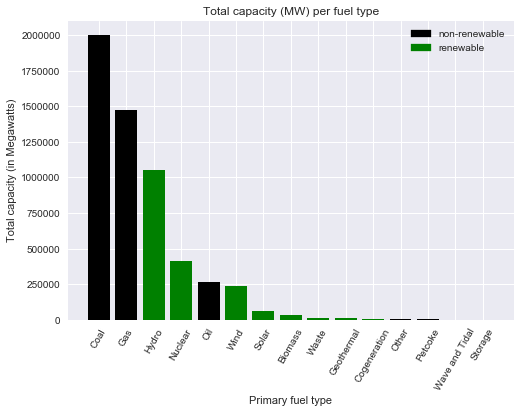

In [213]:
# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
plt.style.use('seaborn')
colors = {0:"black", 1:"green"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
c = capacity['is_green'].apply(lambda x: colors[x])
plt.bar(capacity['primary_fuel'], capacity['capacity_sum'], color=c, label=colors)
plt.xticks(rotation = 60)
plt.title("Total capacity (MW) per fuel type")
plt.xlabel("Primary fuel type")
plt.ylabel("Total capacity (in Megawatts)", rotation = 90)
plt.legend(handles, ["non-renewable", "renewable", "other"])
#plt.savefig(r'plots\tot_cpcty_p_fuel.svg')

**Interpretation:**
Not surprisingly, we see that the first two fuel types are Coal and Gas. However, Hydro also is in the top-three. Nuclear and Oil power plants also seem to be considerable energy producers.

# Maps

Where are the powerplants located around the world? Let's create a map with points for each power plant.

In [166]:
color_dict = {'Solar':'#ffe119', 
          'Gas':'#e6194B', 
          'Oil':'#b15928', 
          'Wind':'#42d4f4', 
          'Hydro':'#4363d8', 
          'Coal':'#fdb462', 
          'Biomass':'#dcbeff', 
          'Waste':'#3cb44b', 
          'Cogeneration':'#d9d9d9', 
          'Geothermal':'#bc80bd', 
          'Nuclear':'#bfef45', 
          'Petcoke':'#ccebc5', 
          'Other':'#fffac8', 
          'Storage':'#469990'}

In [202]:
#Set show_slow_maps to True to show this plot
show_slow_maps = False
if(show_slow_maps):
    fig = px.scatter_geo(df_all,
                        lat=df_all["latitude"],
                        lon=df_all["longitude"],
                        hover_name=df_all["name"],
                        color = df_all["primary_fuel"],
                        color_discrete_map = color_dict,                       
                        title = "Location of Powerplants around the World"
                        )
    fig.show()
    #fig.write_html("plots/map_loc_pp_around_world.html")    

In [168]:
df_pf = (df_all.groupby(['country', 'primary_fuel'], as_index = False)[["capacity_mw"]].sum()
        .sort_values(['country','capacity_mw'], ascending = [True, False], ignore_index = True)
        .drop_duplicates(subset=['country'], keep='first', ignore_index = True))

In [195]:
#plots the countries based on the most used primary fuel types
fig = px.choropleth(df_pf, locations=df_pf["country"],
                    hover_name=df_pf["country"],
                    color = df_pf["primary_fuel"],
                    color_discrete_map = color_dict,
                    title = "Fuel with highest total capacity per country"
                   )
fig.show()
#fig.write_html("plots/map_fuel_highest_tot_capacity_per_country.html")

In [159]:
# Creates new column 'avg_annual_output' in df by
#  - copying estimated_generation_gwh in rows where it is not NaN
#  - averaging the time series in the remaining rows
def annual_output(df):
    df['avg_annual_output'] = df['estimated_generation_gwh']    
    idx = df.index[df['estimated_generation_gwh'].isna()].tolist()    
    df.loc[idx,'avg_annual_output'] = df[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].mean(axis=1)

In [160]:
annual_output(df_all)

In [161]:
df_pf2 = (df_all.groupby(['country', 'primary_fuel'], as_index = False)[["avg_annual_output"]].sum()
        .sort_values(['country','avg_annual_output'], ascending = [True, False], ignore_index = True)
        .drop_duplicates(subset=['country'], keep='first', ignore_index = True))

In [194]:
#plots the countries based on the most used primary fuel types
fig = px.choropleth(df_pf2, locations=df_pf2["country"],
                    hover_name=df_pf2["country"],
                    color = df_pf2["primary_fuel"],
                    color_discrete_map = color_dict,
                    title = "Fuel with highest average annual output per country"
                   )
fig.show()
#fig.write_html("plots/map_fuel_highest_avg_ann_output_per_country.html")

## 2. How many new powerplants in total and of each new fuel type per year (or per n years)

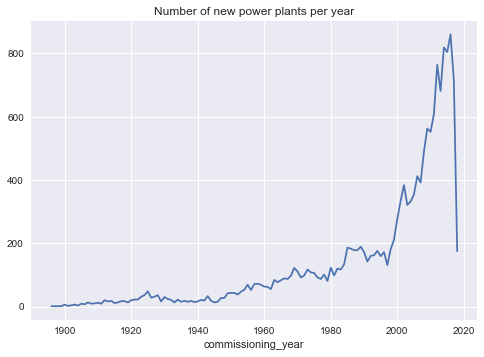

In [215]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
newpp = df_all[['gppd_idnr','country','primary_fuel','commissioning_year']]
newpp = newpp.dropna()
newpp['commissioning_year'] = newpp['commissioning_year'].map(int)
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()
nycountplot = nycount.plot(title = "Number of new power plants per year")
#plt.savefig(r'plots\num_pp_p_year.svg')

**Interpretation:**  Important to note that the energy output data is available only until 2017. We also see a suspicious drop in the amount of new power plants from 2017 to 2018. The latest technical note for the dataset was published in 2019, but almost all sources used are from 2018 (also powerplant data sources). It seems likely that the dataset does not represent the number of new powerplants in 2018 adequately. Therefore, we only include the data from 1896-2017, and explore which fyel types are responsible for the spike(s):

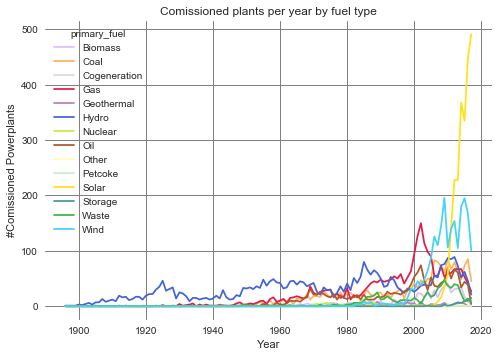

In [187]:
maskyear = newpp["commissioning_year"] != 2018
newpp = newpp[maskyear]
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()
pf_cy = pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"])
fig = (pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"])
        .plot(color = [color_dict.get(x, '#333333') for x in pf_cy.columns]))
plt.title("Comissioned plants per year by fuel type")
plt.xlabel("Year")
plt.grid(color='grey')
ax = plt.gca()
ax.set_facecolor('w')
plt.ylabel("#Comissioned Powerplants")
#plt.savefig(r'plots\comissioned_plants_per_year_by_fuel_type.svg')

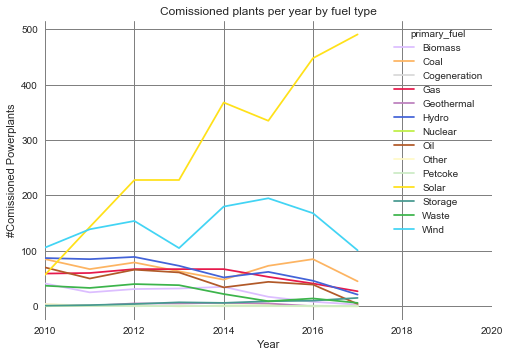

In [188]:
pf_cy.plot(color = [color_dict.get(x, '#333333') for x in pf_cy.columns])
plt.xlim(2010,2020)
plt.title("Comissioned plants per year by fuel type")
plt.xlabel("Year")
plt.ylabel("#Comissioned Powerplants")
plt.grid(color='grey')
ax = plt.gca()
ax.set_facecolor('w')
plt.show()
#plt.savefig(r'plots\comissioned_plants_per_year_by_fuel_type_zoomed.svg')

**Interpretation:** We see that in the recent years, there has been a considerable increase in the number of Solar power plants. We also see that there has been as light increase in the number of new Wind power plants. While not as prominent, there have been new Hydro, Coal, Geothermal, Oil, Biomass power plants. An interesting question is: which countries are responsible for such a  big rise in new Solar power plants?

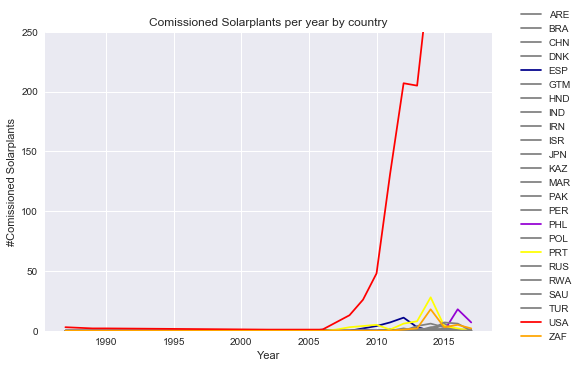

In [209]:
# Exploring which countries are responsible for the spike in solar power plants:
masksolar = newpp["primary_fuel"] == 'Solar'
newsolar = newpp[masksolar]
sol_c_cy = pd.crosstab(newsolar["commissioning_year"], newsolar["country"])
sol_c_cy.plot(color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
plt.ylim(0,250)
plt.title("Comissioned Solarplants per year by country")
plt.xlabel("Year")
plt.ylabel("#Comissioned Solarplants")

plt.legend(bbox_to_anchor=(1.2,1.1))
#plt.savefig(r'plots\comissioned_solar_pp_per_year_by_country.svg')

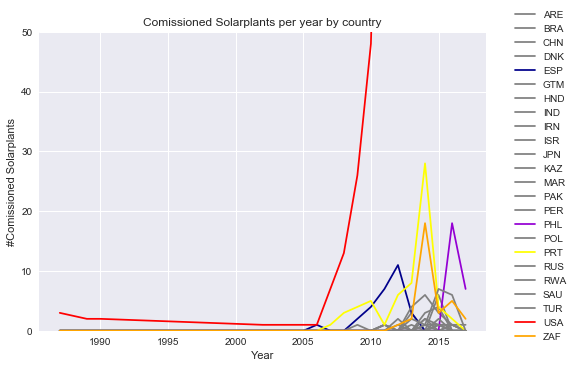

In [208]:
# Zoomed in
sol_c_cy.plot(color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
plt.title("Comissioned Solarplants per year by country")
plt.legend(bbox_to_anchor=(1.2,1.1))
plt.xlabel("Year")
plt.ylabel("#Comissioned Solarplants")
plt.ylim(0,50)

#plt.savefig(r'plots\comissioned_solar_pp_per_year_by_country_zoomed.svg')

**Interpretation:** We see that the most new power plants have been built in USA, but also there has been quite a few new Solar power plants in Spain, Philippines, South Africa, Portugal.

## 3. Ratio green energy estimated output over all estimated output (per country)

In [219]:
df_all["is_green"] = df_all["primary_fuel"].apply(lambda x: green_map[x])
maskgreen = df_all['is_green'] == 1
df_all_green = df_all[maskgreen]

# The green ratio for all the entire dataset
df_all_green['estimated_generation_gwh'].sum()/df_all['estimated_generation_gwh'].sum()

0.336362072576162

<BarContainer object of 164 artists>

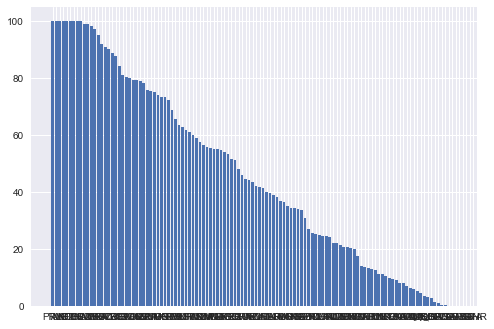

In [220]:
df_all_g = df_all.groupby('country')
df_all_green_g = df_all_green.groupby('country')
totalratiocountry = 100*df_all_green_g['estimated_generation_gwh'].sum()/df_all_g['estimated_generation_gwh'].sum()
totalratiocountry=totalratiocountry.to_frame()
totalratiocountry.reset_index(inplace=True)
totalratiocountry = totalratiocountry.sort_values('estimated_generation_gwh', ascending=False)
totalratiocountry = totalratiocountry.rename(columns={'estimated_generation_gwh':'green_ratio'})
countr = totalratiocountry.groupby('green_ratio')
plt.bar(totalratiocountry['country'],totalratiocountry['green_ratio'])

In [221]:
# Paraguay, Tajikistan, Albania, Mozambique, Nepal, Ethiopia, Switzerland and Iceland have 100 percent green ratio!
# (Googled the country codes)
print(totalratiocountry[totalratiocountry['green_ratio']==100])

    country  green_ratio
127     PRY        100.0
146     TJK        100.0
2       ALB        100.0
105     MOZ        100.0
116     NPL        100.0
50      ETH        100.0
26      CHE        100.0
74      ISL        100.0


In [222]:
# checking the original dataset
masknpl = df_all['country'] == 'NPL'
npl = df_all[masknpl]
npl

,country,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,...,source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh,avg_annual_output,is_green
14528,NPL,Bhote Koshi Hydroelectric Power Plant Nepal,GEODB0040476,45.00,27.9388,85.9450,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,305.591899,305.591899,1
14529,NPL,Devighat Hydroelectric Power Plant Nepal,GEODB0040484,14.10,27.9212,85.1462,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,95.752128,95.752128,1
14530,NPL,Gandak Hydroelectric Power Plant Nepal,GEODB0044203,15.00,27.4268,83.7918,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,101.863966,101.863966,1
14531,NPL,Kali Gandaki Hydroelectric Power Plant Nepal,GEODB0040475,144.00,27.9760,83.5680,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,977.894077,977.894077,1
14532,NPL,Khimti Hydroelectric Power Plant Nepal,GEODB0040485,60.00,27.5500,86.1690,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,407.455865,407.455865,1
14533,NPL,Kulekhani-I Hydroelectric Power Plant Nepal,GEODB0040480,60.00,27.5900,85.1550,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,407.455865,407.455865,1
14534,NPL,Kulekhani-II Hydroelectric Power Plant Nepal,GEODB0040482,32.00,27.5090,85.0519,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,217.309795,217.309795,1
14535,NPL,Marsyangdi Hydroelectric Power Plant Nepal,GEODB0040477,69.00,27.9262,84.4965,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,468.574245,468.574245,1
14536,NPL,Middle Marsyangdi Hydroelectric Power Plant Nepal,GEODB0040478,70.00,28.1890,84.4195,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,475.365176,475.365176,1
14537,NPL,Modi Khola Hydroelectric Power Plant Nepal,GEODB0043974,14.80,28.2720,83.7411,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,100.505780,100.505780,1


In [223]:
#53 countries with green ratio of >= 50
totalratiocountry[totalratiocountry['green_ratio']>=50].nunique()

country        53
green_ratio    46
dtype: int64

**Interpretation:** We see that while there are countries with 100% green ratio and 53 countries with green ration of >= 50%, the total green ratio for all power plants in the data set is only apprx. 33.6%.

## 4. Ratio green energy capacity over all capacity (per country)

<BarContainer object of 164 artists>

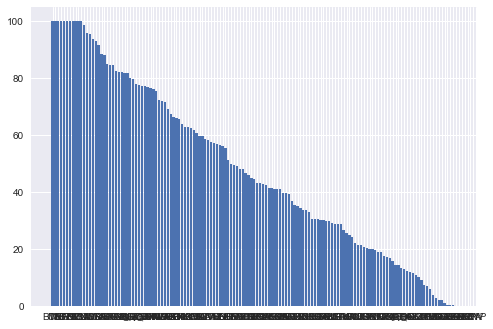

In [224]:
trcapacity = df_all_green_g['capacity_mw'].sum()*100/df_all_g['capacity_mw'].sum()
# https://stackoverflow.com/questions/40224319/pandas-series-to-dataframe-using-series-indexes-as-columns
trcapacity=trcapacity.to_frame()
trcapacity.reset_index(inplace=True)
trcapacity = trcapacity.sort_values('capacity_mw', ascending=False)
trcapacity = trcapacity.rename(columns={'capacity_mw':'green_ratio_capacity'})
plt.bar(trcapacity['country'],trcapacity['green_ratio_capacity'])

In [225]:
# Bhutan, Mali, Zwitzerland, Mozambique, Ethiopia, Paraguay, Eswatini, Iceland, Nepal, Burundi, Lesotho have 
# green capacity ratio of 100! # (Googled the country codes)
print(trcapacity[trcapacity['green_ratio_capacity']==100])

    country  green_ratio_capacity
22      BTN                 100.0
101     MLI                 100.0
26      CHE                 100.0
105     MOZ                 100.0
50      ETH                 100.0
127     PRY                 100.0
142     SWZ                 100.0
74      ISL                 100.0
116     NPL                 100.0
10      BDI                 100.0
92      LSO                 100.0


**Interpretation:** The results are similar to the results above with calculations on the estimated average. It is surprising, however, that some countries (Bhutan, Mali and Lesotho) with 100% green capacity ratio do not have 100% estimated output ratio. A quick check, however, shows that this is because all energy output values are 'NaN' for Bhutan, Mali and Lesotho.

# Complete Time Series Analysis

## 1. Comparison by Year: Boxplot

In [ ]:
annual_output(df_ts_complete)
dfc=df_ts_complete[["generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
dfc.describe()

In [ ]:
dfc.corr()

**Boxplots with outliers:**

In [ ]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
# https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
dfc.boxplot(showfliers=True) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Boxplots without outliers:**

In [ ]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
# https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
dfc.boxplot(showfliers=False) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Interpretation:** It seems like there is a slight rise in energy production from 2013 to 2017, judging by the mean and max values above. However, the boxplots do not seem to show a significant difference. So, is there an increase in energy output throughout the years? Let's use ANOVA hypothesis testing as outlined in the hypothesis testing lecture from the Data Analysis course. So the null hypothesis is that the mean is similar for all 5 years (2013,2014,2015,2016 and 2017). And the alternative hypothesis is that there is a difference between the means.

## 2. Hypothesis Testing

### All

In [ ]:
from scipy.stats import f_oneway
f_oneway(dfc["generation_gwh_2013"],dfc["generation_gwh_2014"],dfc["generation_gwh_2015"],dfc["generation_gwh_2016"],dfc["generation_gwh_2017"])

**Interpretation:** We see that the p-value is quite high, and definitely bigger than the standard 0.05 value. Therefore, we can conclude that the difference in the means between years is most likely due to chance, and that the difference in the means between years is not statistically significant. Let's see if there is a difference year-by-year using the t-test, as outlined in the hypothesis testing lecture from the Data Analysis course:

In [ ]:
from scipy.stats import ttest_ind
t34, pval34 = ttest_ind(dfc["generation_gwh_2013"],dfc["generation_gwh_2014"])
print(t34, pval34)

In [ ]:
t45, pval45= ttest_ind(dfc["generation_gwh_2014"],dfc["generation_gwh_2015"])
print(t45, pval45)

In [ ]:
t56, pval56 = ttest_ind(dfc["generation_gwh_2015"],dfc["generation_gwh_2016"])
print(t56, pval56)

In [ ]:
t67, pval67 = ttest_ind(dfc["generation_gwh_2016"],dfc["generation_gwh_2017"])
print(t67, pval67)

**Interpretation:** There does not seem to be a significant difference as all p-values are higher than 0.05. The p-value steadily decrease with years, though. Now, it would be interesting to look specifically at Solar and Wind energy outputs, as from the plots above we see that there have been quite a lot of new power plants of these fuel types.

### Solar and Wind only

In [ ]:
dfc1=df_ts_complete[["primary_fuel","generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
solar= dfc1[dfc1["primary_fuel"].str.contains('Solar')==True] 
solar.describe()

In [ ]:
from scipy.stats import f_oneway
f_oneway(solar["generation_gwh_2013"],solar["generation_gwh_2014"],solar["generation_gwh_2015"],solar["generation_gwh_2016"],solar["generation_gwh_2017"])

**Interpretation:** The p-value is pretty small, but still a bit bigger than 0.05. Let's look year-by-year:

In [ ]:
t34, pval34 = ttest_ind(solar["generation_gwh_2013"],solar["generation_gwh_2014"])
print(t34, pval34)

In [ ]:
t45, pval45= ttest_ind(solar["generation_gwh_2014"],solar["generation_gwh_2015"])
print(t45, pval45)

In [ ]:
t56, pval56 = ttest_ind(solar["generation_gwh_2015"],solar["generation_gwh_2016"])
print(t56, pval56)

In [ ]:
t67, pval67 = ttest_ind(solar["generation_gwh_2016"],solar["generation_gwh_2017"])
print(t67, pval67)

**Interpretation:** So only for 2013-2014, the difference in mean could have been statistically significant. This is interesting, considering how many new power plants there have been built in 2010-2017, and that the country which seems to be responsible for the spike in new solar power plants seem to be the US (which is included in the complete time series dataset). Let's not look at wind:

In [ ]:
wind = dfc1[dfc1["primary_fuel"].str.contains('Wind')==True] 
wind["primary_fuel"].unique()
wind.describe()

In [ ]:
from scipy.stats import f_oneway
f_oneway(wind["generation_gwh_2013"],wind["generation_gwh_2014"],wind["generation_gwh_2015"],wind["generation_gwh_2016"],wind["generation_gwh_2017"])

In [ ]:
t34, pval34 = ttest_ind(wind["generation_gwh_2013"],wind["generation_gwh_2014"])
print(t34, pval34)

In [ ]:
t45, pval45= ttest_ind(wind["generation_gwh_2014"],wind["generation_gwh_2015"])
print(t45, pval45)

In [ ]:
t56, pval56 = ttest_ind(wind["generation_gwh_2015"],wind["generation_gwh_2016"])
print(t56, pval56)

In [ ]:
t67, pval67 = ttest_ind(wind["generation_gwh_2016"],wind["generation_gwh_2017"])
print(t67, pval67)

**Interpretation:** Not statistically significant.

## 3. Stacked barplot energy output per fuel type (separate for each country)

In [ ]:
dfc2=df_ts_complete[["country","primary_fuel","generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
aus = dfc2[dfc2["country"].str.contains('AUS')==True] 
ind = dfc2[dfc2["country"].str.contains('IND')==True] 
usa = dfc2[dfc2["country"].str.contains('USA')==True] 
ausfuel = aus.groupby("primary_fuel")

# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
ausfuel = ausfuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
ausfuel = ausfuel.sort_values(by='generation_2013_sum', ascending = False)
ausfuel = ausfuel.transpose() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
ausfuel = ausfuel.reset_index()

indfuel = ind.groupby("primary_fuel")
# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
indfuel = indfuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
indfuel = indfuel.sort_values(by='generation_2013_sum', ascending = False)
indfuel = indfuel.transpose() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
indfuel = indfuel.reset_index()

usafuel = usa.groupby("primary_fuel")
# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
usafuel = usafuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
usafuel = usafuel.sort_values(by='generation_2013_sum', ascending = False)
usafuel = usafuel.transpose() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
usafuel = usafuel.reset_index()

In [ ]:
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
p1 = plt.bar(ausfuel["index"], ausfuel["Coal"], color='brown')
p2 = plt.bar(ausfuel["index"], ausfuel["Gas"] ,bottom = ausfuel["Coal"], color='coral')
p3 = plt.bar(ausfuel["index"], ausfuel["Hydro"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"])], color='blue')
p4 = plt.bar(ausfuel["index"], ausfuel["Wind"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"])],
             color='cyan')
p5 = plt.bar(ausfuel["index"], ausfuel["Waste"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"])],
             color='beige')
p6 = plt.bar(ausfuel["index"], ausfuel["Oil"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"],ausfuel["Waste"])],
             color='red')
p7 = plt.bar(ausfuel["index"], ausfuel["Solar"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"],ausfuel["Waste"],ausfuel["Oil"])],
             color='yellow')
plt.ylim(0,200000)
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Gas':"coral", 'Hydro':"blue","Wind":"cyan", "Waste":"beige","Oil":"red","Solar":"yellow"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("Australia")

In [ ]:
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
p1 = plt.bar(indfuel["index"], indfuel["Coal"], color='brown')
p2 = plt.bar(indfuel["index"], indfuel["Hydro"] ,bottom = indfuel["Coal"], color='blue')
p3 = plt.bar(indfuel["index"], indfuel["Gas"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"])], color='coral')
p4 = plt.bar(indfuel["index"], indfuel["Nuclear"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"],indfuel["Gas"])],
             color='lime')
p5 = plt.bar(indfuel["index"], indfuel["Oil"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"],indfuel["Gas"], indfuel["Nuclear"])],
             color='red')
plt.ylim(0,1000000)
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Hydro':"blue", 'Gas':"coral", "Nuclear":"lime","Oil":"red"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("India")

In [ ]:
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
p1 = plt.bar(usafuel["index"], usafuel["Coal"], color='brown')
p2 = plt.bar(usafuel["index"], usafuel["Gas"] ,bottom = usafuel["Coal"], color='coral')
p3 = plt.bar(usafuel["index"], usafuel["Nuclear"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"])], color='lime')
p4 = plt.bar(usafuel["index"], usafuel["Hydro"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"])],
             color='blue')
p5 = plt.bar(usafuel["index"], usafuel["Wind"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"])],
             color='cyan')
p6 = plt.bar(usafuel["index"], usafuel["Waste"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"])],
             color='beige')
p7 = plt.bar(usafuel["index"], usafuel["Biomass"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"])],
             color='green')
p8 = plt.bar(usafuel["index"], usafuel["Geothermal"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"])],
             color='orange')
p9 = plt.bar(usafuel["index"], usafuel["Oil"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"])],
             color='red')
p10 = plt.bar(usafuel["index"], usafuel["Petcoke"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"])],
             color='darkblue')
p11 = plt.bar(usafuel["index"], usafuel["Solar"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"])],
             color='yellow')
p12 = plt.bar(usafuel["index"], usafuel["Cogeneration"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"])],
             color='grey')
p13 = plt.bar(usafuel["index"], usafuel["Storage"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"],usafuel["Cogeneration"])],
             color='violet')
p14 = plt.bar(usafuel["index"], usafuel["Other"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"],usafuel["Cogeneration"],usafuel["Storage"])],
             color='white')
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Gas':"coral", "Nuclear":"lime", "Hydro":"blue","Wind":"cyan","Waste":"beige","Biomass":"green","Geothermal":"orange","Oil":"red","Petcoke":"darkblue","Solar":"yellow","Cogeneration":"grey","Storage":"violet","Other":"white"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("USA")

**Interpretation:** We see that Coal and Gas are still major energy providers for Australia, India and USA. Nuclear, Hydro and Wind energies are also relatively important.

## 4. Line plot: ratio of energy output sustainable fuel types over total energy output per year

In [ ]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
ausfuel['green'] = ausfuel["Hydro"]+ausfuel["Wind"]+ausfuel["Waste"]+ausfuel["Solar"]
ausfuel['all'] = ausfuel[list(ausfuel.columns)].sum(axis=1)
ausfuel['greenpercent'] = ausfuel['green']*100/ausfuel['all']
ausfuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("Australia")

In [ ]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
indfuel['green'] = indfuel["Hydro"]+indfuel["Nuclear"]
indfuel['all'] = indfuel[list(indfuel.columns)].sum(axis=1)
indfuel['greenpercent'] = indfuel['green']*100/indfuel['all']
indfuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("India")

In [ ]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
usafuel['green'] = usafuel["Nuclear"]+usafuel["Hydro"]+usafuel["Wind"]+usafuel["Waste"]+usafuel["Biomass"]+usafuel["Geothermal"]+usafuel["Solar"]
usafuel['all'] = usafuel[list(usafuel.columns)].sum(axis=1)
usafuel['greenpercent'] = usafuel['green']*100/usafuel['all']
usafuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("USA")

**Interpretation:** We see that unfortunately, neither Australia nor India or USA has a clear constant upward trend in the percentage of green energy output, and that in 2017 that percentage actually decreased for all three countries when compared to 2013.

# Regression on the full dataset (predicting annual energy generation)

**Reminder:** annual energy generation is either the average of actually reported generations between 2013-2017, or the energy generation estimated by the database creators.

**Not accounting for multicolinearity:**

In [ ]:
model1 = sm.ols(formula="avg_annual_output ~ capacity_mw+latitude+longitude+primary_fuel+green+commissioning_year", data=df_all).fit()
model1.summary()

**Accounting for colinearity:**

In [ ]:
model12 = sm.ols(formula="avg_annual_output ~ capacity_mw+latitude+longitude+primary_fuel+green+commissioning_year+capacity_mw*primary_fuel+capacity_mw*commissioning_year+primary_fuel*commissioning_year+latitude*longitude", data=df_all).fit()
model12.summary()

**Interpretation:** We see that 'primary_fuel' variable on its own still can have low p-values but the combination of capacity and primary fuel looks much better in terms of p-values. 'Capacity_mw' and 'green' do not have low p-values anymore after accounting for multicolinearity. Latitude and Commissioning year did not have a high p-value from the very beginning, but the combination of longitude and latitude does, as well as the combination of 'capacity_mw' and 'commissioning_year'. Therefore, let's only keep 'longitude:latitude', 'primary_fuel:capacity' and 'capacity:commissioning_year' 

In [ ]:
model123 = sm.ols(formula="avg_annual_output ~ latitude*longitude+capacity_mw*primary_fuel+capacity_mw*commissioning_year", data=df_all).fit()
model123.summary()

# Analysis on US Data

In [328]:
_, df_ts_complete, *_ = read_clean_and_split()

In [329]:
df_US = df_ts_complete[df_ts_complete['country'] == 'USA']

In [330]:
# Adds a column with us_state to dataframe df
# The used library for reverse geocoding works with K-D trees.
# Might produce inaccurate results for border regions
def coordinate_to_state(df):
    
    coordinates = [*zip(df['latitude'], df['longitude'])]
    #Uncomment below to include (lat, long) tuple as new column in df
    #df.insert(4, 'coordinates', coordinates)

    geo_infos = rg.search(tuple(coordinates))

    locations = list()

    for item in geo_infos:
        locations.append(item['admin1'])

    df.insert(1, 'us_state', locations)   


In [331]:
# Fixes the obvious mistakes made by coordinate_to_state function (where us_state is not a US state)
# Based on looking up the locations manually
def fix_misclassification(df):
    #British Columbia
    df.at['USA0054249', 'us_state'] = 'Idaho'
    df.loc[df['us_state']=='British Columbia', 'us_state'] = 'Washington'
    
    #Quebec
    df.at['USA0056829', 'us_state'] = 'Maine'
    df.loc[df['us_state']=='Quebec', 'us_state'] = 'New York'
    
    #Baja California
    df.at['USA0000120', 'us_state'] = 'Arizona'
    df.loc[df['us_state']=='Baja California', 'us_state'] = 'California'
    
    #Ontario 
    df.at['USA0006369', 'us_state'] = 'Michigan'
    df.at['USA0010487', 'us_state'] = 'Minnesota'
    df.at['USA0002694', 'us_state'] = 'New York'
    
    #Chukotskiy Avtonomnyy Okrug
    df.loc[df['us_state']=='Chukotskiy Avtonomnyy Okrug', 'us_state'] = 'Alaska'
    
    #Tamaulipas
    df.loc[df['us_state']=='Tamaulipas', 'us_state'] = 'Texas'
    
    #Yukon
    df.loc[df['us_state']=='Yukon', 'us_state'] = 'Alaska'   

In [332]:
coordinate_to_state(df_US)
fix_misclassification(df_US)

In [333]:
df_US['us_state'].value_counts()

California          912
New York            327
Texas               320
Minnesota           255
Iowa                213
North Carolina      207
Michigan            199
Pennsylvania        185
Illinois            183
New Jersey          182
Wisconsin           169
Massachusetts       160
Washington          132
Idaho               127
Ohio                126
Alaska              125
Florida             125
Oregon              124
Colorado            124
Kansas              117
Virginia            116
Georgia             113
Indiana             100
Missouri             95
South Carolina       93
Arizona              93
Nebraska             90
Maine                89
Oklahoma             77
Connecticut          75
Louisiana            75
Alabama              72
Utah                 67
New Mexico           65
Maryland             63
Nevada               63
New Hampshire        60
Wyoming              58
Vermont              57
Tennessee            53
Arkansas             52
Montana         

In [334]:
df_US.primary_fuel.unique()

array(['Solar', 'Gas', 'Oil', 'Wind', 'Hydro', 'Coal', 'Biomass', 'Waste',
       'Cogeneration', 'Geothermal', 'Nuclear', 'Petcoke', 'Other',
       'Storage'], dtype=object)

In [344]:
fig = go.Figure(data=go.Scattergeo(
        lon = df_US['longitude'],
        lat = df_US['latitude'],
        text = df_US['primary_fuel'],
        mode = 'markers',
        marker_color = df_US['primary_fuel'].apply(lambda x: color_dict[x]),
        ))

fig.update_layout(
        title = 'Powerplants US',
        geo_scope='usa',
    )
fig.show()

In [347]:
fig = px.scatter_geo(df_US,
                        lat=df_US["latitude"],
                        lon=df_US["longitude"],
                        hover_name=df_US["name"],
                        color = df_US["primary_fuel"],
                        color_discrete_map = color_dict,                       
                        title = 'Location of Powerplants U.S.',
                        geo_scope='usa'
                        )
fig.update_layout(
        
    )
fig.show()

In [336]:
df_US['is_green'] = df_US['primary_fuel'].apply(lambda x: green_map[x])

In [337]:
#Returns a pivot table containing the ratio of green fuel generation / total fuel generation per year per state
def green_ratio_per_state(df_US):
    df_US = df_US[df_US['primary_fuel']!='Other']
    df_US['green_gwh_2013'] = df_US['generation_gwh_2013']*df_US['is_green']
    df_US['green_gwh_2014'] = df_US['generation_gwh_2014']*df_US['is_green']
    df_US['green_gwh_2015'] = df_US['generation_gwh_2015']*df_US['is_green']
    df_US['green_gwh_2016'] = df_US['generation_gwh_2016']*df_US['is_green']
    df_US['green_gwh_2017'] = df_US['generation_gwh_2017']*df_US['is_green']
    
    values = ['generation_gwh_2013', 'green_gwh_2013', 'generation_gwh_2014', 'green_gwh_2014', 'generation_gwh_2015', 'green_gwh_2015', 'generation_gwh_2016', 'green_gwh_2016','generation_gwh_2017', 'green_gwh_2017']

    pt = pd.pivot_table(df_US,index=["us_state"], values=values, aggfunc=np.sum)
    
    pt['2013'] = pt['green_gwh_2013']/pt['generation_gwh_2013']
    pt['2014'] = pt['green_gwh_2014']/pt['generation_gwh_2014']
    pt['2015'] = pt['green_gwh_2015']/pt['generation_gwh_2015']
    pt['2016'] = pt['green_gwh_2016']/pt['generation_gwh_2016']
    pt['2017'] = pt['green_gwh_2017']/pt['generation_gwh_2017']
    
    pt = pt.drop('Washington, D.C.') #has only one powerplant

    return pt, pt[['2013','2014', '2015','2016','2017']]

In [338]:
_, pt = green_ratio_per_state(df_US)
pt

,2013,2014,2015,2016,2017
us_state,,,,,
Alabama,0.449954,0.453324,0.437674,0.454043,0.399506
Alaska,0.254428,0.312361,0.334680,0.359345,0.296758
Arizona,0.349336,0.405376,0.406509,0.418049,0.408148
Arkansas,0.257145,0.286701,0.339753,0.300151,0.271968
California,0.401862,0.385123,0.378653,0.481645,0.525750
Colorado,0.102204,0.114266,0.105093,0.119395,0.113537
Connecticut,0.712929,0.695986,0.514323,0.498962,0.527072
Delaware,0.902666,0.922609,0.808972,0.805701,0.840813
Florida,0.237783,0.272312,0.286022,0.280565,0.185365


In [339]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [340]:
# plotting libraries expect stat-code as input
states = list(pt.index)
pt['code']=list(map(lambda x: us_state_abbrev[x], states))
pt

,2013,2014,2015,2016,2017,code
us_state,,,,,,
Alabama,0.449954,0.453324,0.437674,0.454043,0.399506,AL
Alaska,0.254428,0.312361,0.334680,0.359345,0.296758,AK
Arizona,0.349336,0.405376,0.406509,0.418049,0.408148,AZ
Arkansas,0.257145,0.286701,0.339753,0.300151,0.271968,AR
California,0.401862,0.385123,0.378653,0.481645,0.525750,CA
Colorado,0.102204,0.114266,0.105093,0.119395,0.113537,CO
Connecticut,0.712929,0.695986,0.514323,0.498962,0.527072,CT
Delaware,0.902666,0.922609,0.808972,0.805701,0.840813,DE
Florida,0.237783,0.272312,0.286022,0.280565,0.185365,FL


In [341]:
#px.chloropleth expects data in a certain shape, so we need to reshape

pt['us_state'] = pt.index

pt2 = pt.melt(id_vars=['us_state', 'code'], 
        var_name='year', 
        value_name='Green fuels (%)')

pt2

,us_state,code,year,Green fuels (%)
0,Alabama,AL,2013,0.449954
1,Alaska,AK,2013,0.254428
2,Arizona,AZ,2013,0.349336
3,Arkansas,AR,2013,0.257145
4,California,CA,2013,0.401862
...,...,...,...,...
245,Virginia,VA,2017,0.482137
246,Washington,WA,2017,0.875378
247,West Virginia,WV,2017,0.036933
248,Wisconsin,WI,2017,0.230767


In [343]:
fig = px.choropleth(pt2, 
              locations='code', 
              locationmode = 'USA-states', 
              scope = 'usa', 
              color="Green fuels (%)", 
              hover_name="Green fuels (%)", 
              hover_data=['us_state'],
              animation_frame="year",              
              color_continuous_scale=["white", "green"])

fig.update_layout(
    title_text = 'U.S. Green over non-Green fuels by State',
)
fig.show()
#fig.write_html("plots/map_us_green_ratio_states.html")

## Statistical Analyses

### Correlation Analysis

In [ ]:
df_US.drop(['year_of_capacity_data', 'estimated_generation_gwh'], axis=1, inplace=True)
df_US

In [ ]:
# Constructs a pairplot, similar to scatter matrix, to visualize the correlation with powerplants color coded by green, not green or other
seaborn.pairplot(df_US, hue = 'is_green', palette = 'bright')

In [ ]:
#Constructs a heatmap for correlation coefficient using seaborn
import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize = (16,10))
seaborn.heatmap(df_US.corr(), annot = True, cmap = "coolwarm")

**Interpretation:**

In the US, from the visualizations above, production capacity_mw and actual energy generation for years 2013-2017 seem to be highly correlated. And moreover, the energy generation year by year seem to be highly correlated with each other. So, in the next section we shall build a regression model for the year 2017 generation based on these correlated variables. 

### Regression Models

#### Simple linear models

In [ ]:
# Builds a simple linear model for energy generation 2017 based on production capacity_mw
import statsmodels.formula.api as sm

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ capacity_mw", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2013

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2013", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2014

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2014", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2015

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2015", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

In [ ]:
# Builds a simple linear model for energy generation 2017 based on energy generated in 2016

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ generation_gwh_2016", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

**Interpretation:**

In building the simple linear models for the US, we found out that for estimating the 2017 energy generation, the data from the 2015 had the highest R-squared coefficient among everyone at 0.892. However, for other years were also quite close, with 2016 being 0.890, 2013 being 0.864 and 2014 being 0.861. Contrary to our correlation matrix, the data for capacity_mw was not a particularly strong predictor for energy generation in 2017 with a R-squared coefficient of 0.728. So, to build a even stronger model, we try to build a multilinear regression model based on energy generation from 2013-2016. 

### Multilinear Regression model

In [ ]:
# Builds a multilinear model for energy generation 2017 based on energy generated in years 2013-2016

generation_gwh_2017_ols = sm.ols(formula="generation_gwh_2017 ~ capacity_mw + generation_gwh_2013 + generation_gwh_2014 + generation_gwh_2015 + generation_gwh_2016", data=df_US).fit() 
generation_gwh_2017_ols.summary() 

**Interpretation:**

Based on our simple linear models above, we built a multilinear regression model for predicting the energy generation in 2017 based on data from 2013-2016 and the production capacity_mw. And we have a very strong model with a R-squared coefficient of 0.932 meaning that this model will be useful for prediction. Next we use the cross validation method to find out the robustness of this model.

### Cross Validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Applying the cross validation method

X = df_US[['capacity_mw', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016']]
y = df_US["generation_gwh_2017"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) # 67% of data in training set, 33% in the test set
lr = LinearRegression()
lr.fit(X = X_train, y = y_train)
print ("Training accuracy: ",lr.score(X_train, y_train))
print ("Test accuracy: ", lr.score(X_test, y_test))

**Interpretation:**

Using cross validation, we see that our model can correctly predict 93.5% of the training set and 91.7% of the test dataset. This means that our multilinear regression model will correctly predict the dependent value in 91.7% of the points that were not used to train the model, which is quite good.

### Logistic Regression model

In [ ]:
import statsmodels.api as sm

#Green fuels = 1, non-green fuels = 0, other = 0
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], 0))

df_US['is_green'] = df_US['primary_fuel'].apply(lambda x: green_map[x])

#Build a logistic regression model based on the following variables to predict whether a poweplant is green or not

x_train = df_US[['capacity_mw', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']] 
y_train = df_US[['is_green']] 
logit_reg = sm.Logit(y_train, x_train).fit()
print(logit_reg.summary()) 

**Interpretation:**

We tried to build a logistic regression model to predict whether a given powerplant is green or not based on the variables capacity_mw and energy generated from 2013-2017. However, the model is not very good at predicting it. 


### Hypothesis testing - has there been an increase in energy output between years (2013-2017) in the US?

In [ ]:
df_US1 =df_US[["generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
df_US1.describe()

#### Boxplot

In [ ]:
# Draws a boxplot for energy generation between 2013 -2017
df_US1.boxplot(showfliers=False)
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Interpretation:**

There does not really seem to be an increase in output between 2013 and 2014 since the mean has decreased. For 2014-15, there seems to be an increase in average generation, which we shall investigate. And similarily, there seems to be an increase in average energy generation between 2016-17, shown also in the boxplot. This too, we shall investigate. 

#### T-tests - Investigating year by year change

In [ ]:
from scipy.stats import ttest_ind
# conducts a t-test to investigate difference in energy generation between 2014 and 2015

t1, pval1 = ttest_ind(df_US1["generation_gwh_2014"],df_US1["generation_gwh_2015"])
print(t1, pval1)

In [ ]:
# conducts a t-test to investigate difference in energy generation between 2016 and 2017

t2, pval2 = ttest_ind(df_US1["generation_gwh_2016"],df_US1["generation_gwh_2017"])
print(t2, pval2)

**Interpretation:**

Our t-tests indicate that there has not really been a increase in output between 2014 and 2015 as can be seen by the p-value which is quite high. The average increase might be because of randomness. However, for the years 2016 and 2017, the case is rather interesting. As seen by increase in mean, the t-test shows that if we take a significance level of 5%, the p-value is greater meaning that the difference is not statistically significant. However, at a signifance level of 10 or 15%, the difference is statistically significant. So, we cannot just rule out the difference as occuring because of random chance. 

In [ ]:
#Returns a pivot table containing the absolute change per year in energy generation between states
def abs_change_per_state(df_US):
    
    values = ['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']

    pt = pd.pivot_table(df_US,index=["us_state"], values=values, aggfunc=np.sum)
    
    pt['2013'] = abs(pt['generation_gwh_2013'] - pt['generation_gwh_2013'])
    pt['2014'] = abs(pt['generation_gwh_2014'] - pt['generation_gwh_2013'])
    pt['2015'] = abs(pt['generation_gwh_2015'] - pt['generation_gwh_2014'])
    pt['2016'] = abs(pt['generation_gwh_2016'] - pt['generation_gwh_2015'])
    pt['2017'] = abs(pt['generation_gwh_2017'] - pt['generation_gwh_2016'])
    
    
    return pt, pt[['2013','2014', '2015','2016','2017']]

In [ ]:
_, pt = abs_change_per_state(df_US)
pt